In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [ ]:
df_train = pd.read_csv(train_file_path, sep='\t', names=['type', 'message'])   ## turn tsv data into a df
df_test = pd.read_csv(test_file_path, sep='\t', names=['type','message'])

In [ ]:
df_train.head()

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [ ]:
df_test.tail()

,type,message
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...
1391,spam,not heard from u4 a while. call 4 rude chat pr...


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     1392 non-null   object
 1   message  1392 non-null   object
dtypes: object(2)
memory usage: 21.9+ KB


In [ ]:
pd.isna(df_train).sum()

type       0
message    0
dtype: int64

In [ ]:
pd.isna(df_test).sum()

type       0
message    0
dtype: int64

In [ ]:
## encode message type numerically

df_train['type'] = pd.factorize(df_train['type'])[0]
df_test['type'] = pd.factorize(df_test['type'])[0]

In [ ]:
df_train.head()

,type,message
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
df_test.tail()

,type,message
1387,0,true dear..i sat to pray evening and felt so.s...
1388,0,"what will we do in the shower, baby?"
1389,0,where are you ? what are you doing ? are yuou ...
1390,1,ur cash-balance is currently 500 pounds - to m...
1391,1,not heard from u4 a while. call 4 rude chat pr...


In [ ]:
train_labels = df_train['type'].values
test_labels = df_test['type'].values

In [ ]:
train_labels

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
## classification task. ..input function to convert input data into tf.data.Dataset. ..
## shape of ds important to properly fit into the model, have to be careful with feeding the features and labels here. ..

train_ds = tf.data.Dataset.from_tensor_slices((df_train['message'].values, train_labels))

train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((df_test['message'], test_labels))

test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
## shuffle and batch

buffer_size = 1000
batch_size = 32

train_ds = train_ds.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)   ## prefetch: optimize data loading and preprocessing, improve training efficiency
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
## adding a text vectorization layer - encoding categorical data (long string texts) numerically for our model. ..

vec = TextVectorization(output_mode = 'int',
                        max_tokens = 1000,
                        output_sequence_length = 1000,)

vec.adapt(train_ds.map(lambda text, label :text))  ## vectorize each message (text string). ..adapt to input data for sts properties

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]                              ## peak at the vocabulary the text vec got from vectorizing the text messages in the input ds. ..

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [ ]:
## basic model architecture. ..
## (could also use tf.estimator.DNNClassifier as a high-level API, but for more flexibility and purpose-spec customization of the model)
## would rather build it from "scratch". ..
## sice we're handling text messages. ..some elements of NLP come into play


model =  tf.keras.Sequential([
    vec,              ## text vectorization layer
    tf.keras.layers.Embedding(len(vec.get_vocabulary()), 64, mask_zero= True ),  ## word embedding layer (encode each word as a dense vector in the context of the message)
                                                                                 ## 64: n-dim in embedding vetors, mask_zero for dealing with sequences of varying length (take 0 as a padding value)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),   ## 64 nodes in LSTM memory corr. to 64 dims in embedding vectors, return full sequence of output from each input
                                                                                      ## Bidirectional wrapper: for LSTM layer to process input in both forward and backward, learn information from both past and future contexts. ..
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1000, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    validation_steps = 30,
                    epochs = 10,)

Epoch 1/10
131/131 [==============================] - 634s 5s/step - loss: 0.6056 - accuracy: 0.8660 - val_loss: 0.4932 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 699s 5s/step - loss: 0.3909 - accuracy: 0.8660 - val_loss: 0.2669 - val_accuracy: 0.8604
Epoch 3/10
131/131 [==============================] - 606s 5s/step - loss: 0.1695 - accuracy: 0.9234 - val_loss: 0.1137 - val_accuracy: 0.9667
Epoch 4/10
131/131 [==============================] - 530s 4s/step - loss: 0.0897 - accuracy: 0.9801 - val_loss: 0.0762 - val_accuracy: 0.9781
Epoch 5/10
131/131 [==============================] - 510s 4s/step - loss: 0.0683 - accuracy: 0.9861 - val_loss: 0.0653 - val_accuracy: 0.9844
Epoch 6/10
131/131 [==============================] - 527s 4s/step - loss: 0.0550 - accuracy: 0.9871 - val_loss: 0.0616 - val_accuracy: 0.9875
Epoch 7/10
131/131 [==============================] - 523s 4s/step - loss: 0.0450 - accuracy: 0.9897 - val_loss: 0.0582 - val_accuracy: 0.9885

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

44/44 [==============================] - 32s 732ms/step - loss: 0.0616 - accuracy: 0.9856
Test loss: 0.061594408005476
Test accuracy: 0.9856321811676025


In [ ]:
history.history

{'loss': [0.6055920720100403,
  0.3909153938293457,
  0.16953006386756897,
  0.08970583230257034,
  0.06829395145177841,
  0.05501522868871689,
  0.04501938074827194,
  0.03816014900803566,
  0.030258405953645706,
  0.026346974074840546],
 'accuracy': [0.8659966588020325,
  0.8659966588020325,
  0.923426628112793,
  0.9801387786865234,
  0.9861210584640503,
  0.9870782494544983,
  0.9897104501724243,
  0.9918640851974487,
  0.9937784075737,
  0.9944962859153748],
 'val_loss': [0.4932076334953308,
  0.2668868601322174,
  0.11366526037454605,
  0.07616006582975388,
  0.06534028798341751,
  0.06163793057203293,
  0.05815134570002556,
  0.05719880387187004,
  0.06041479483246803,
  0.0653982013463974],
 'val_accuracy': [0.8604166507720947,
  0.8604166507720947,
  0.9666666388511658,
  0.9781249761581421,
  0.984375,
  0.987500011920929,
  0.9885416626930237,
  0.987500011920929,
  0.987500011920929,
  0.9864583611488342]}

In [ ]:
def plot(h, metric):
  plt.plot(h.history[metric])
  plt.plot(h.history['val_'+metric])   ## 'val_' + metric (concatenate): take the metric for the validation (intead of the training). ..
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6345543269068002)

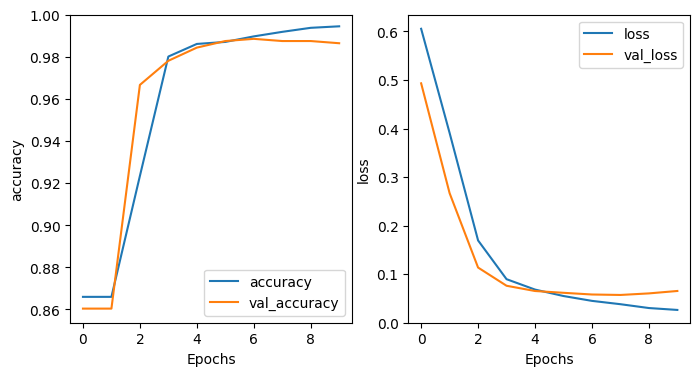

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot(history, 'loss')
plt.ylim(0, None)

In [ ]:
## see accuracy levels at a max at about 1 epochs and loss approaches a min. ..10 epochs should suffice (hopefully ;) )

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  pred_type = model.predict([pred_text])
  t_code = pred_type[0][0]
  prediction = [t_code, 'ham' if t_code < 0.5 else 'spam']
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 7s 7s/step
[-6.070001, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 299ms/step
You passed the challenge. Great job!
